In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import os

In [51]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [52]:
def batch_elastic_transform(images, sigma, alpha, height, width, random_state=None):
    """
    Elastic deformation of images as described in [Simard 2003].

    Args:
        images: a two-dimensional numpy array; list of flattened images
        sigma: variance of the gaussian kernel
        alpha: multiplier for the displacement fields
        height: image height
        width: image width
        random_state: numpy random state object

    Returns:
        elastically distorted images of the same shape
    """
    assert len(images.shape) == 2
    e_images = np.empty_like(images)
    e_images[:] = images

    e_images = e_images.reshape(-1, height, width)

    if random_state is None:
        random_state = np.random.RandomState(None)
    x, y = np.mgrid[0:height, 0:width]

    for i in range(e_images.shape[0]):
        dx = gaussian_filter((random_state.rand(height, width) * 2 - 1),
                           sigma, mode='constant') * alpha
        dy = gaussian_filter((random_state.rand(height, width) * 2 - 1),
                           sigma, mode='constant') * alpha
        indices = x + dx, y + dy
        e_images[i] = map_coordinates(e_images[i], indices, order=1)

    return e_images.reshape(-1, height*width)

In [53]:
random_state = np.random.RandomState(None)
dx1 = random_state.rand(28, 28) * 2 - 1
dy1 = random_state.rand(28, 28) * 2 - 1
dx2 = gaussian_filter(dx1, 4, mode='constant')
dy2 = gaussian_filter(dy1, 4, mode='constant')

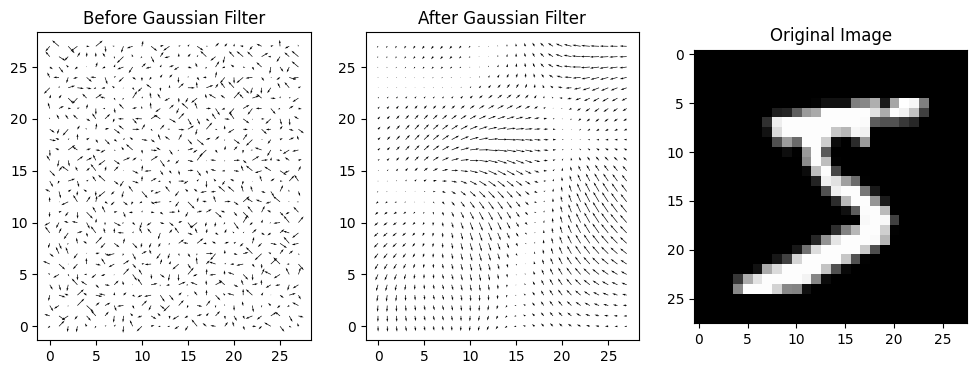

In [54]:
x, y = np.mgrid[0:28, 0:28]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.quiver(x, y, dx1, dy1)
plt.title('Before Gaussian Filter')
plt.subplot(132)
plt.quiver(x, y, dx2, dy2)
plt.title('After Gaussian Filter')
# Demonstrate elastic transform on MNIST image
img = x_train[0]
plt.subplot(133)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

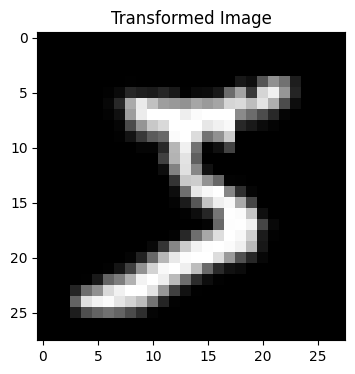

In [55]:
transformed_img = batch_elastic_transform(
    img.reshape(1, -1),
    sigma=4,
    alpha=20,
    height=28,
    width=28
)

plt.figure(figsize=(4, 4))
plt.imshow(transformed_img.reshape(28, 28), cmap='gray')
plt.title('Transformed Image')
plt.show()

In [56]:
def transform_dataset(x_train, batch_size=1000, sigma=4, alpha=20):
    """
    Transform entire dataset in batches to avoid memory issues
    """
    height, width = x_train.shape[1:]
    n_samples = x_train.shape[0]

    # Initialize array for transformed images
    transformed_images = np.zeros((n_samples, height * width))

    # Process in batches
    for i in tqdm(range(0, n_samples, batch_size)):
        batch_end = min(i + batch_size, n_samples)
        batch = x_train[i:batch_end]

        # Reshape batch to 2D array (n_samples, pixels)
        batch_flat = batch.reshape(batch_end - i, -1)

        # Apply transformation
        transformed = batch_elastic_transform(
            batch_flat,
            sigma=sigma,
            alpha=alpha,
            height=height,
            width=width
        )

        transformed_images[i:batch_end] = transformed

    return transformed_images

In [57]:
transformed_train = transform_dataset(x_train)

100%|███████████████████████████████████████████| 60/60 [00:05<00:00, 10.23it/s]


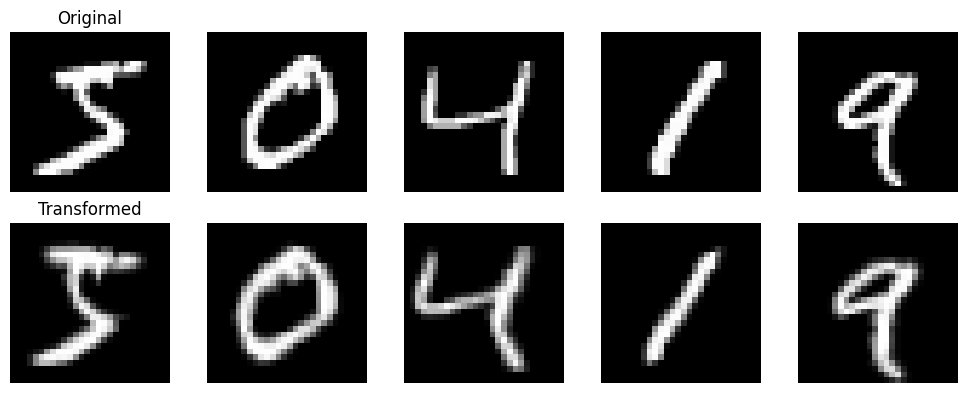

In [58]:
def plot_comparison(original, transformed, num_images=5):
    plt.figure(figsize=(2*num_images, 4))

    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        # Transformed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(transformed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Transformed')

    plt.tight_layout()
    plt.show()

# Plot some examples
plot_comparison(x_train, transformed_train)

In [59]:
def list_of_norms(X):
    """
    Computes squared L2 norm for each vector in X.

    Args:
        X: tensor of shape [n, d] containing n d-dimensional vectors

    Returns:
        tensor of shape [n] containing squared L2 norms
    """
    return tf.reduce_sum(tf.pow(X, 2), axis=1)

In [60]:
def list_of_distances(X, Y):
    """
    Computes pairwise squared Euclidean distances between two sets of vectors.

    Args:
        X: tensor of shape [n, d] containing n d-dimensional vectors
        Y: tensor of shape [m, d] containing m d-dimensional vectors

    Returns:
        tensor of shape [n, m] containing all pairwise distances
    """
    XX = tf.reshape(list_of_norms(X), shape=(-1, 1))
    YY = tf.reshape(list_of_norms(Y), shape=(1, -1))
    output = XX + YY - 2 * tf.matmul(X, tf.transpose(Y))

    return output

In [61]:
class PrototypeAutoencoder(tf.keras.Model):
    def __init__(self, input_shape, n_classes, n_prototypes=15):
        super(PrototypeAutoencoder, self).__init__()
        # Network parameters
        self.n_prototypes = n_prototypes
        self.input_shape = input_shape
        self.n_classes = n_classes

        # Encoder layers
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(10, 3, strides=1, padding='same', activation='sigmoid'),
            tf.keras.layers.Flatten()
        ])

        # Decoder layers
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=(160,)),
            tf.keras.layers.Dense(4*4*10),
            tf.keras.layers.Reshape((4, 4, 10)),
            tf.keras.layers.Conv2DTranspose(32, 3, strides=1, padding='valid', activation='relu'),  # 4x4x32
            tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),  # 8x8x32
            tf.keras.layers.Conv2DTranspose(32, 3, strides=1, padding='valid', activation='relu'),  # 14x14x32
            tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid') # 28x28x1
        ])

        # Prototype vectors
        self.prototype_vectors = tf.Variable(
            tf.random.uniform(shape=[n_prototypes, 4*4*10], dtype=tf.float32),
            name='prototype_vectors'
        )

        # Classification layer
        self.classifier = tf.keras.layers.Dense(n_classes)

        print(self.encoder.summary())
        print(self.decoder.summary())


    def call(self, inputs):
        # Ensure input shape is correct
        if len(inputs.shape) == 2:
            inputs = tf.reshape(inputs, [-1, 28, 28, 1])

        # Encode
        features = self.encoder(inputs)

        # Calculate distances to prototypes
        prototype_distances = list_of_distances(features, self.prototype_vectors)

        # Get logits
        logits = self.classifier(prototype_distances)

        # Decode
        decoded = self.decoder(features)

        return logits, decoded, features, prototype_distances

In [62]:
def train_step(model, optimizer, x, y, lambda_params):
    with tf.GradientTape() as tape:
        # Forward pass
        x = tf.reshape(x, [-1, 28, 28, 1])
        logits, decoded, features, prototype_distances = model(x)

        # Calculate losses
        classification_loss = tf.reduce_mean(
            tf.keras.losses.categorical_crossentropy(y, logits, from_logits=True)
        )
        x_flat = tf.reshape(x, [-1, 784])
        decoded_flat = tf.reshape(decoded, [-1, 784])

        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(x_flat, decoded_flat)
        )

        # Prototype losses
        feature_distances = list_of_distances(model.prototype_vectors, features)
        error_1 = tf.reduce_mean(tf.reduce_min(feature_distances, axis=1))
        error_2 = tf.reduce_mean(tf.reduce_min(prototype_distances, axis=1))

        # Total loss
        total_loss = (lambda_params['class'] * classification_loss +
                     lambda_params['ae'] * reconstruction_loss +
                     lambda_params['1'] * error_1 +
                     lambda_params['2'] * error_2)

    # Backpropagation
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Return losses as a dictionary
    return {
        'classification': classification_loss,
        'reconstruction': reconstruction_loss,
        'error_1': error_1,
        'error_2': error_2,
        'total': total_loss
    }

In [63]:
def visualize_reconstructions(model, dataset):
    # Get multiple batches of images and select diverse samples
    sample_images = []
    for x_batch, _ in dataset.take(5):
        # Select 2 random images from each batch
        indices = tf.random.shuffle(tf.range(x_batch.shape[0]))[:2]
        sample_images.extend(tf.gather(x_batch, indices))
        if len(sample_images) >= 10:
            break

    sample_images = tf.stack(sample_images[:10])
    sample_images = tf.reshape(sample_images, [-1, 28, 28, 1])  # Ensure 4D shape

    # Reconstruct images
    _, reconstructed, _, _ = model(sample_images)

    # Plot results
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    plt.suptitle('Original Images (top) vs Reconstructed Images (bottom)', y=1.05)

    for i in range(10):
        # Ensure proper shape for visualization
        orig_img = tf.squeeze(sample_images[i]).numpy()
        recon_img = tf.squeeze(reconstructed[i]).numpy()

        axes[0, i].imshow(orig_img, cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_img, cmap='gray')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [65]:
def train_model(model, train_dataset, valid_dataset, test_dataset, epochs=150,
                learning_rate=0.0001, batch_size=250, log_dir="logs"):

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    lambda_params = {'class': 10, 'ae': 1, '1': 10, '2': 5}
    print(lambda_params)
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training loop
        for x_batch, y_batch in train_dataset:
            # Apply elastic transform
            x_batch = tf.reshape(x_batch, [-1, 28, 28, 1])
            x_flat = tf.reshape(x_batch, [-1, 784])
            x_batch_elastic = batch_elastic_transform(x_flat, sigma=4, alpha=20,
                                                      height=28, width=28)
            losses = train_step(model, optimizer, x_batch_elastic, y_batch, lambda_params)

        # Validation
        val_accuracy = tf.keras.metrics.CategoricalAccuracy()
        for x_val, y_val in valid_dataset:
            logits, _, _, _ = model(x_val)
            val_accuracy.update_state(y_val, logits)

        # Print results for the epoch
        losses_cleaned = {key: float(value.numpy()) for key, value in losses.items()}
        print(f"Validation accuracy: {val_accuracy.result().numpy():.4f}, Loss: {losses_cleaned}\n")
    
        # Generate and print prototypes every 50 epochs
        # if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        #     # Decode prototype vectors to image space
        #     prototypes = model.prototype_vectors.numpy()

        #     # Use the decoder with prototype vectors reshaped to match encoder output
        #     decoded_prototypes = model.decoder(prototypes.reshape(-1, 4, 4, 10)).numpy()

        #     # Reshape to 28x28 images
        #     decoded_prototypes = decoded_prototypes.reshape(-1, 28, 28)

        #     # Plot decoded prototypes
        #     plt.figure(figsize=(15, 6))
        #     for i in range(len(decoded_prototypes)):
        #         plt.subplot(2, 8, i + 1)
        #         plt.imshow(decoded_prototypes[i], cmap='gray')
        #         plt.title(f'Prototype {i}')
        #         plt.axis('off')
        #     plt.tight_layout()
        #     plt.suptitle(f'Final Learned Prototypes at Epoch {epoch+1}', y=1.02)
        #     plt.show()

In [66]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [67]:
# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(250)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_test[:5000], y_test[:5000])).batch(250)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test[5000:], y_test[5000:])).batch(250)

In [68]:
# Create and train model
model = PrototypeAutoencoder(input_shape=(28, 28, 1), n_classes=10, n_prototypes=15)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 4, 4, 10)       │         2,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 160)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,706 (84.79 KB)

 Trainable params: 21,706 (84.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 160)            │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 4, 4, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_24             │ (None, 6, 6, 32)       │         2,912 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_25             │ (None, 12, 12, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,457 (185.38 KB)

 Trainable params: 47,457 (185.38 KB)

 Non-trainable params: 0 (0.00 B)

None


In [69]:
train_model(model, train_dataset, valid_dataset, test_dataset)

Epoch 1/150


2024-12-11 14:20:19.333558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:20:19.637350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.1164, Loss: {'classification': 5.963315486907959, 'reconstruction': 0.3658057451248169, 'error_1': 12.808551788330078, 'error_2': 9.042642593383789, 'total': 263.1142578125}

Epoch 2/150


2024-12-11 14:20:50.238696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:20:50.525925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.4278, Loss: {'classification': 3.45352840423584, 'reconstruction': 0.2822161912918091, 'error_1': 12.1531982421875, 'error_2': 6.953816890716553, 'total': 208.38621520996094}

Epoch 3/150


2024-12-11 14:21:20.184486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:21:20.464894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.5564, Loss: {'classification': 1.7703783512115479, 'reconstruction': 0.269151508808136, 'error_1': 11.696179389953613, 'error_2': 6.223525524139404, 'total': 174.9042510986328}

Epoch 4/150


2024-12-11 14:21:50.353953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:21:50.625911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.6896, Loss: {'classification': 1.2357168197631836, 'reconstruction': 0.25653332471847534, 'error_1': 11.31375503540039, 'error_2': 5.057051181793213, 'total': 157.215087890625}

Epoch 5/150


2024-12-11 14:22:19.973980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:22:20.238318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7278, Loss: {'classification': 1.1240683794021606, 'reconstruction': 0.2368125319480896, 'error_1': 11.069145202636719, 'error_2': 4.655911922454834, 'total': 151.06884765625}

Epoch 6/150


2024-12-11 14:22:49.721889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:22:50.001945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7450, Loss: {'classification': 1.079593539237976, 'reconstruction': 0.22229014337062836, 'error_1': 10.68117904663086, 'error_2': 4.646856307983398, 'total': 146.46226501464844}

Epoch 7/150


2024-12-11 14:23:19.935285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:23:20.215673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7576, Loss: {'classification': 0.9967716932296753, 'reconstruction': 0.20531700551509857, 'error_1': 10.674310684204102, 'error_2': 4.577240467071533, 'total': 144.78619384765625}

Epoch 8/150


2024-12-11 14:23:49.446410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:23:49.717153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7704, Loss: {'classification': 0.9115968346595764, 'reconstruction': 0.1949586570262909, 'error_1': 10.021732330322266, 'error_2': 4.461747169494629, 'total': 136.3949737548828}

Epoch 9/150


2024-12-11 14:24:19.632807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:24:19.895306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7772, Loss: {'classification': 0.8809758424758911, 'reconstruction': 0.1874539703130722, 'error_1': 10.169059753417969, 'error_2': 4.42168664932251, 'total': 137.2011260986328}

Epoch 10/150


2024-12-11 14:24:49.777401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:24:50.022521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7822, Loss: {'classification': 0.8920741677284241, 'reconstruction': 0.1812899261713028, 'error_1': 9.80050277709961, 'error_2': 4.386724472045898, 'total': 133.5010528564453}

Epoch 11/150


2024-12-11 14:25:20.958396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:25:21.212726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7902, Loss: {'classification': 0.8165814280509949, 'reconstruction': 0.17797863483428955, 'error_1': 9.912193298339844, 'error_2': 4.3024091720581055, 'total': 133.0606689453125}

Epoch 12/150


2024-12-11 14:25:54.866212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:25:55.120444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7932, Loss: {'classification': 0.7571743726730347, 'reconstruction': 0.17523297667503357, 'error_1': 9.327939987182617, 'error_2': 4.231067180633545, 'total': 125.96759033203125}

Epoch 13/150


2024-12-11 14:26:29.399730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:26:29.691884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.7998, Loss: {'classification': 0.7719882130622864, 'reconstruction': 0.17358393967151642, 'error_1': 10.003839492797852, 'error_2': 4.217595100402832, 'total': 132.87977600097656}

Epoch 14/150


2024-12-11 14:27:03.320007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:27:03.592788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8074, Loss: {'classification': 0.7637726068496704, 'reconstruction': 0.17066949605941772, 'error_1': 9.343232154846191, 'error_2': 4.109574317932129, 'total': 125.60745239257812}

Epoch 15/150


2024-12-11 14:27:36.191355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:27:36.451457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8140, Loss: {'classification': 0.7706137895584106, 'reconstruction': 0.1698967069387436, 'error_1': 9.992955207824707, 'error_2': 4.131346702575684, 'total': 132.3153839111328}

Epoch 16/150


2024-12-11 14:28:09.543925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:28:09.816150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8198, Loss: {'classification': 0.728240430355072, 'reconstruction': 0.16665907204151154, 'error_1': 9.398558616638184, 'error_2': 4.190978527069092, 'total': 126.03074645996094}

Epoch 17/150


2024-12-11 14:28:40.124237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:28:40.373234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8198, Loss: {'classification': 0.699493944644928, 'reconstruction': 0.1647971272468567, 'error_1': 8.885002136230469, 'error_2': 4.224666118621826, 'total': 120.63055419921875}

Epoch 18/150


2024-12-11 14:29:11.729374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:29:12.036958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8230, Loss: {'classification': 0.7028446197509766, 'reconstruction': 0.16510984301567078, 'error_1': 9.09009838104248, 'error_2': 4.096807956695557, 'total': 122.09280395507812}

Epoch 19/150


2024-12-11 14:29:43.699950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:29:44.030835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8258, Loss: {'classification': 0.7457095980644226, 'reconstruction': 0.1621999889612198, 'error_1': 9.390974044799805, 'error_2': 4.151811599731445, 'total': 126.01664733886719}

Epoch 20/150


2024-12-11 14:30:14.600858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:30:14.871263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8260, Loss: {'classification': 0.6630338430404663, 'reconstruction': 0.16273829340934753, 'error_1': 9.10257625579834, 'error_2': 4.131387233734131, 'total': 121.79094696044922}

Epoch 21/150


2024-12-11 14:30:47.167290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:30:47.475561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8314, Loss: {'classification': 0.6829772591590881, 'reconstruction': 0.16184717416763306, 'error_1': 9.625059127807617, 'error_2': 4.140542984008789, 'total': 127.35981750488281}

Epoch 22/150


2024-12-11 14:31:19.520794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:31:19.824049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8330, Loss: {'classification': 0.6399509310722351, 'reconstruction': 0.16154992580413818, 'error_1': 8.786479949951172, 'error_2': 4.1591315269470215, 'total': 118.4212646484375}

Epoch 23/150


2024-12-11 14:31:49.887761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:31:50.182037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8348, Loss: {'classification': 0.6718230843544006, 'reconstruction': 0.16045936942100525, 'error_1': 8.546751022338867, 'error_2': 4.110377311706543, 'total': 116.25720977783203}

Epoch 24/150


2024-12-11 14:32:20.400556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:32:20.677809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8384, Loss: {'classification': 0.6451460123062134, 'reconstruction': 0.15938277542591095, 'error_1': 8.204431533813477, 'error_2': 4.0767717361450195, 'total': 112.26473999023438}

Epoch 25/150


2024-12-11 14:32:50.851141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:32:51.150150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8414, Loss: {'classification': 0.6345680356025696, 'reconstruction': 0.15780824422836304, 'error_1': 9.45432186126709, 'error_2': 4.095010280609131, 'total': 124.6946029663086}

Epoch 26/150


2024-12-11 14:33:21.244463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:33:21.531813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8416, Loss: {'classification': 0.5890791416168213, 'reconstruction': 0.15851056575775146, 'error_1': 8.347871780395508, 'error_2': 4.117912292480469, 'total': 113.06297302246094}

Epoch 27/150


2024-12-11 14:33:52.046350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:33:52.314988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8432, Loss: {'classification': 0.6339943408966064, 'reconstruction': 0.15644186735153198, 'error_1': 8.561078071594238, 'error_2': 4.073361396789551, 'total': 115.6439437866211}

Epoch 28/150


2024-12-11 14:34:23.322197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:34:23.602309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8450, Loss: {'classification': 0.6218205690383911, 'reconstruction': 0.15659697353839874, 'error_1': 9.149616241455078, 'error_2': 4.04091739654541, 'total': 121.18466186523438}

Epoch 29/150


2024-12-11 14:34:52.908440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:34:53.172446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8444, Loss: {'classification': 0.6964357495307922, 'reconstruction': 0.1589512825012207, 'error_1': 8.240703582763672, 'error_2': 4.014798641204834, 'total': 113.08651733398438}

Epoch 30/150


2024-12-11 14:35:23.139612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:35:23.454616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8476, Loss: {'classification': 0.625664472579956, 'reconstruction': 0.15720386803150177, 'error_1': 7.984541893005371, 'error_2': 3.956160068511963, 'total': 109.16838836669922}

Epoch 31/150


2024-12-11 14:35:53.172057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:35:53.439184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8508, Loss: {'classification': 0.6212140321731567, 'reconstruction': 0.15514825284481049, 'error_1': 8.833173751831055, 'error_2': 3.9573404788970947, 'total': 117.59180450439453}

Epoch 32/150


2024-12-11 14:36:23.311080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:36:23.593093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8540, Loss: {'classification': 0.593453049659729, 'reconstruction': 0.15429644286632538, 'error_1': 8.436853408813477, 'error_2': 4.070258140563965, 'total': 113.77590942382812}

Epoch 33/150


2024-12-11 14:36:52.866509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:36:53.145268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8504, Loss: {'classification': 0.6517122983932495, 'reconstruction': 0.15730005502700806, 'error_1': 8.486959457397461, 'error_2': 3.8609161376953125, 'total': 114.10716247558594}

Epoch 34/150


2024-12-11 14:37:22.851465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:37:23.120725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8568, Loss: {'classification': 0.571631133556366, 'reconstruction': 0.15534751117229462, 'error_1': 8.608213424682617, 'error_2': 4.063133239746094, 'total': 115.12761688232422}

Epoch 35/150


2024-12-11 14:37:52.841373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:37:53.123396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8572, Loss: {'classification': 0.5286753177642822, 'reconstruction': 0.15509457886219025, 'error_1': 9.113245010375977, 'error_2': 3.971844434738159, 'total': 119.07688903808594}

Epoch 36/150


2024-12-11 14:38:22.908523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:38:23.181268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8562, Loss: {'classification': 0.6224485635757446, 'reconstruction': 0.15557736158370972, 'error_1': 8.73198127746582, 'error_2': 3.9263341426849365, 'total': 116.44378662109375}

Epoch 37/150


2024-12-11 14:38:52.898894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:38:53.178201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8618, Loss: {'classification': 0.5689876079559326, 'reconstruction': 0.1549840271472931, 'error_1': 8.750303268432617, 'error_2': 4.062489032745361, 'total': 116.50527954101562}

Epoch 38/150


2024-12-11 14:39:22.958821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:39:23.229435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8604, Loss: {'classification': 0.6294512152671814, 'reconstruction': 0.15576381981372833, 'error_1': 8.83720588684082, 'error_2': 4.053608417510986, 'total': 118.23763275146484}

Epoch 39/150


2024-12-11 14:39:52.561107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:39:52.831101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8632, Loss: {'classification': 0.6146737337112427, 'reconstruction': 0.15291331708431244, 'error_1': 8.466870307922363, 'error_2': 3.9174044132232666, 'total': 113.62873840332031}

Epoch 40/150


2024-12-11 14:40:23.327001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:40:23.626428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8610, Loss: {'classification': 0.5524532198905945, 'reconstruction': 0.15569177269935608, 'error_1': 8.498723983764648, 'error_2': 3.9305155277252197, 'total': 113.08231353759766}

Epoch 41/150


2024-12-11 14:40:53.488618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:40:53.844421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8636, Loss: {'classification': 0.5011534094810486, 'reconstruction': 0.15264087915420532, 'error_1': 8.37269115447998, 'error_2': 3.8517463207244873, 'total': 110.65559387207031}

Epoch 42/150


2024-12-11 14:41:25.095288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:41:25.404342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8654, Loss: {'classification': 0.5616827607154846, 'reconstruction': 0.1556619554758072, 'error_1': 8.39419174194336, 'error_2': 3.7965426445007324, 'total': 111.50553131103516}

Epoch 43/150


2024-12-11 14:41:56.272994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:41:56.585262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8668, Loss: {'classification': 0.5807161331176758, 'reconstruction': 0.15418611466884613, 'error_1': 8.388226509094238, 'error_2': 3.816497564315796, 'total': 111.82968139648438}

Epoch 44/150


2024-12-11 14:42:28.234433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:42:28.547347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8686, Loss: {'classification': 0.5601806640625, 'reconstruction': 0.15483707189559937, 'error_1': 8.663445472717285, 'error_2': 3.8897316455841064, 'total': 114.64065551757812}

Epoch 45/150


2024-12-11 14:42:59.568486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:42:59.857265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8678, Loss: {'classification': 0.5701085925102234, 'reconstruction': 0.15297150611877441, 'error_1': 8.042698860168457, 'error_2': 3.833116292953491, 'total': 108.29716491699219}

Epoch 46/150


2024-12-11 14:43:30.405386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:43:30.686870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8658, Loss: {'classification': 0.5126846432685852, 'reconstruction': 0.15509311854839325, 'error_1': 7.902670383453369, 'error_2': 4.000694751739502, 'total': 106.87553405761719}

Epoch 47/150


2024-12-11 14:44:04.869539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:44:05.177540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8684, Loss: {'classification': 0.5038756728172302, 'reconstruction': 0.15328361093997955, 'error_1': 7.726287841796875, 'error_2': 3.765798568725586, 'total': 103.80329132080078}

Epoch 48/150


2024-12-11 14:44:36.078548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:44:36.359764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8698, Loss: {'classification': 0.47949472069740295, 'reconstruction': 0.1537923663854599, 'error_1': 7.750202655792236, 'error_2': 3.9141480922698975, 'total': 104.41898345947266}

Epoch 49/150


2024-12-11 14:45:07.796586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:45:08.149617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8704, Loss: {'classification': 0.5398881435394287, 'reconstruction': 0.15272608399391174, 'error_1': 7.8062591552734375, 'error_2': 3.907768726348877, 'total': 105.85247802734375}

Epoch 50/150


2024-12-11 14:45:37.890391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:45:38.173345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8730, Loss: {'classification': 0.5427629947662354, 'reconstruction': 0.15388089418411255, 'error_1': 8.61300277709961, 'error_2': 3.884695529937744, 'total': 113.84883117675781}

Epoch 51/150


2024-12-11 14:46:08.990680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:46:09.322567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8708, Loss: {'classification': 0.5405691862106323, 'reconstruction': 0.1532461941242218, 'error_1': 7.707319736480713, 'error_2': 3.804995536804199, 'total': 104.35995483398438}

Epoch 52/150


2024-12-11 14:46:38.559459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:46:38.834123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8692, Loss: {'classification': 0.5461620092391968, 'reconstruction': 0.15270355343818665, 'error_1': 7.369530200958252, 'error_2': 3.8676862716674805, 'total': 101.37886810302734}

Epoch 53/150


2024-12-11 14:47:09.124235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:47:09.413718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8720, Loss: {'classification': 0.5072821378707886, 'reconstruction': 0.15337128937244415, 'error_1': 8.031856536865234, 'error_2': 3.9015469551086426, 'total': 107.58890533447266}

Epoch 54/150


2024-12-11 14:47:38.797010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:47:39.114942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8718, Loss: {'classification': 0.4786038398742676, 'reconstruction': 0.15364883840084076, 'error_1': 7.558359622955322, 'error_2': 3.8943464756011963, 'total': 102.3880386352539}

Epoch 55/150


2024-12-11 14:48:09.481405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:48:09.774443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8740, Loss: {'classification': 0.5138531923294067, 'reconstruction': 0.15307368338108063, 'error_1': 7.917797088623047, 'error_2': 3.853437662124634, 'total': 106.3060302734375}

Epoch 56/150


2024-12-11 14:48:40.374248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:48:40.679102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8756, Loss: {'classification': 0.497408926486969, 'reconstruction': 0.1502896547317505, 'error_1': 8.340855598449707, 'error_2': 3.742525577545166, 'total': 109.73260498046875}

Epoch 57/150


2024-12-11 14:49:10.566714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:49:10.856601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8746, Loss: {'classification': 0.584694504737854, 'reconstruction': 0.15248194336891174, 'error_1': 8.290508270263672, 'error_2': 3.875593423843384, 'total': 111.20594787597656}

Epoch 58/150


2024-12-11 14:49:40.326641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:49:40.611064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8766, Loss: {'classification': 0.4808415472507477, 'reconstruction': 0.15225589275360107, 'error_1': 7.664821624755859, 'error_2': 3.706757068634033, 'total': 102.546875}

Epoch 59/150


2024-12-11 14:50:10.010874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:50:10.340399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8732, Loss: {'classification': 0.5218942761421204, 'reconstruction': 0.15336884558200836, 'error_1': 7.369211196899414, 'error_2': 3.731158971786499, 'total': 100.32968139648438}

Epoch 60/150


2024-12-11 14:50:39.352861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:50:39.644732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8766, Loss: {'classification': 0.4900049567222595, 'reconstruction': 0.15277566015720367, 'error_1': 7.977675437927246, 'error_2': 3.804694652557373, 'total': 106.30308532714844}

Epoch 61/150


2024-12-11 14:51:09.126778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:51:09.406957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8770, Loss: {'classification': 0.4990025460720062, 'reconstruction': 0.15051783621311188, 'error_1': 8.441709518432617, 'error_2': 3.8103151321411133, 'total': 111.10423278808594}

Epoch 62/150


2024-12-11 14:51:38.360124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:51:38.635086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8774, Loss: {'classification': 0.5062036514282227, 'reconstruction': 0.1526041328907013, 'error_1': 8.024041175842285, 'error_2': 3.819173812866211, 'total': 107.08193969726562}

Epoch 63/150


2024-12-11 14:52:07.881528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:52:08.159335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8732, Loss: {'classification': 0.4896866977214813, 'reconstruction': 0.15487918257713318, 'error_1': 7.8193039894104, 'error_2': 3.708808660507202, 'total': 104.23726654052734}

Epoch 64/150


2024-12-11 14:52:37.267814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:52:37.551284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8760, Loss: {'classification': 0.4886573255062103, 'reconstruction': 0.15215729176998138, 'error_1': 7.941963195800781, 'error_2': 3.6899921894073486, 'total': 105.35160827636719}

Epoch 65/150


2024-12-11 14:53:06.941912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:53:07.242771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8790, Loss: {'classification': 0.5223193168640137, 'reconstruction': 0.15187281370162964, 'error_1': 7.853424072265625, 'error_2': 3.6832544803619385, 'total': 104.93717956542969}

Epoch 66/150


2024-12-11 14:53:36.582306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:53:36.866448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8812, Loss: {'classification': 0.46012380719184875, 'reconstruction': 0.1517931967973709, 'error_1': 7.271631240844727, 'error_2': 3.694196939468384, 'total': 98.2409439086914}

Epoch 67/150


2024-12-11 14:54:06.208857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:54:06.513429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8786, Loss: {'classification': 0.5361536741256714, 'reconstruction': 0.15088364481925964, 'error_1': 7.74062442779541, 'error_2': 3.6133663654327393, 'total': 103.66626739501953}

Epoch 68/150


2024-12-11 14:54:35.580528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:54:35.854103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8792, Loss: {'classification': 0.4781968891620636, 'reconstruction': 0.1508190631866455, 'error_1': 7.258378028869629, 'error_2': 3.6810190677642822, 'total': 98.3126449584961}

Epoch 69/150


2024-12-11 14:55:05.238907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:55:05.524609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8770, Loss: {'classification': 0.5076918005943298, 'reconstruction': 0.15125896036624908, 'error_1': 8.141608238220215, 'error_2': 3.718968152999878, 'total': 107.7775650024414}

Epoch 70/150


2024-12-11 14:55:34.551249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:55:34.830648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8790, Loss: {'classification': 0.5068838596343994, 'reconstruction': 0.15109436213970184, 'error_1': 8.346396446228027, 'error_2': 3.715329170227051, 'total': 109.79496765136719}

Epoch 71/150


2024-12-11 14:56:04.145743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:56:04.438027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8802, Loss: {'classification': 0.4649598002433777, 'reconstruction': 0.15063723921775818, 'error_1': 7.794158935546875, 'error_2': 3.797305107116699, 'total': 104.05314636230469}

Epoch 72/150


2024-12-11 14:56:33.564720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:56:33.841067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8804, Loss: {'classification': 0.47288575768470764, 'reconstruction': 0.15322422981262207, 'error_1': 7.313188552856445, 'error_2': 3.794706344604492, 'total': 99.3519287109375}

Epoch 73/150


2024-12-11 14:57:03.103786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:57:03.384936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8780, Loss: {'classification': 0.5467418432235718, 'reconstruction': 0.15171237289905548, 'error_1': 8.27843189239502, 'error_2': 3.6919240951538086, 'total': 109.59678649902344}

Epoch 74/150


2024-12-11 14:57:32.360310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:57:32.641398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8842, Loss: {'classification': 0.515012800693512, 'reconstruction': 0.14923278987407684, 'error_1': 7.785033702850342, 'error_2': 3.641871690750122, 'total': 103.93412017822266}

Epoch 75/150


2024-12-11 14:58:01.882219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:58:02.162226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8854, Loss: {'classification': 0.47607314586639404, 'reconstruction': 0.15014958381652832, 'error_1': 8.124403953552246, 'error_2': 3.6706602573394775, 'total': 106.88858795166016}

Epoch 76/150


2024-12-11 14:58:31.204517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:58:31.481049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8834, Loss: {'classification': 0.43379998207092285, 'reconstruction': 0.1505611091852188, 'error_1': 8.039814949035645, 'error_2': 3.773733139038086, 'total': 105.92437744140625}

Epoch 77/150


2024-12-11 14:59:00.759044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:59:01.036714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8818, Loss: {'classification': 0.5414679646492004, 'reconstruction': 0.14915402233600616, 'error_1': 7.463155269622803, 'error_2': 3.642789363861084, 'total': 101.11666870117188}

Epoch 78/150


2024-12-11 14:59:30.129291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 14:59:30.408799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8840, Loss: {'classification': 0.4594128131866455, 'reconstruction': 0.14915230870246887, 'error_1': 7.720709323883057, 'error_2': 3.702092409133911, 'total': 102.75789642333984}

Epoch 79/150


2024-12-11 14:59:59.738972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:00:00.043563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8836, Loss: {'classification': 0.48381751775741577, 'reconstruction': 0.15084314346313477, 'error_1': 8.247392654418945, 'error_2': 3.604132890701294, 'total': 107.90269470214844}

Epoch 80/150


2024-12-11 15:00:29.028176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:00:29.306801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8826, Loss: {'classification': 0.48796114325523376, 'reconstruction': 0.15026642382144928, 'error_1': 7.536029815673828, 'error_2': 3.5768322944641113, 'total': 100.71414184570312}

Epoch 81/150


2024-12-11 15:00:58.799635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:00:59.077475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8844, Loss: {'classification': 0.48917117714881897, 'reconstruction': 0.15166780352592468, 'error_1': 6.877418041229248, 'error_2': 3.7891509532928467, 'total': 95.20916748046875}

Epoch 82/150


2024-12-11 15:01:28.071869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:01:28.352374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8852, Loss: {'classification': 0.49505966901779175, 'reconstruction': 0.15085254609584808, 'error_1': 8.489361763000488, 'error_2': 3.6069729328155518, 'total': 110.50523376464844}

Epoch 83/150


2024-12-11 15:01:57.386253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:01:57.666271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8870, Loss: {'classification': 0.49147868156433105, 'reconstruction': 0.1518198549747467, 'error_1': 7.961145877838135, 'error_2': 3.562279462814331, 'total': 104.94685363769531}

Epoch 84/150


2024-12-11 15:02:26.924759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:02:27.198786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8880, Loss: {'classification': 0.5284350514411926, 'reconstruction': 0.1484849900007248, 'error_1': 6.952949047088623, 'error_2': 3.660444974899292, 'total': 95.90672302246094}

Epoch 85/150


2024-12-11 15:02:56.254839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:02:56.535246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8866, Loss: {'classification': 0.44372445344924927, 'reconstruction': 0.14971953630447388, 'error_1': 8.21804428100586, 'error_2': 3.787740468978882, 'total': 107.92472839355469}

Epoch 86/150


2024-12-11 15:03:25.896595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:03:26.190307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8888, Loss: {'classification': 0.3732646405696869, 'reconstruction': 0.14795218408107758, 'error_1': 7.236780643463135, 'error_2': 3.50897479057312, 'total': 95.65960693359375}

Epoch 87/150


2024-12-11 15:03:55.276362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:03:55.561716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8868, Loss: {'classification': 0.48653751611709595, 'reconstruction': 0.14958444237709045, 'error_1': 7.683708667755127, 'error_2': 3.669097423553467, 'total': 102.6302261352539}

Epoch 88/150


2024-12-11 15:04:24.821049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:04:25.106905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8902, Loss: {'classification': 0.5729154348373413, 'reconstruction': 0.14861588180065155, 'error_1': 8.205241203308105, 'error_2': 3.599827289581299, 'total': 108.79389953613281}

Epoch 89/150


2024-12-11 15:04:54.135007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:04:54.412778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8880, Loss: {'classification': 0.41519972681999207, 'reconstruction': 0.14921756088733673, 'error_1': 7.6880364418029785, 'error_2': 3.7178709506988525, 'total': 101.84693145751953}

Epoch 90/150


2024-12-11 15:05:23.707142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:05:23.987166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8910, Loss: {'classification': 0.43085506558418274, 'reconstruction': 0.15036064386367798, 'error_1': 7.725869655609131, 'error_2': 3.562108039855957, 'total': 101.68242645263672}

Epoch 91/150


2024-12-11 15:05:53.012013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:05:53.294644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8916, Loss: {'classification': 0.5361739993095398, 'reconstruction': 0.1487046480178833, 'error_1': 7.131697177886963, 'error_2': 3.6108710765838623, 'total': 97.56263732910156}

Epoch 92/150


2024-12-11 15:06:22.709167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:06:22.989299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8912, Loss: {'classification': 0.5372399091720581, 'reconstruction': 0.1495242416858673, 'error_1': 6.8748393058776855, 'error_2': 3.6499836444854736, 'total': 95.20642852783203}

Epoch 93/150


2024-12-11 15:06:52.094608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:06:52.376676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8914, Loss: {'classification': 0.5074442625045776, 'reconstruction': 0.14841310679912567, 'error_1': 6.953125953674316, 'error_2': 3.693427085876465, 'total': 95.75846862792969}

Epoch 94/150


2024-12-11 15:07:21.657271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:07:21.934955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8902, Loss: {'classification': 0.5589014291763306, 'reconstruction': 0.15173141658306122, 'error_1': 8.01336669921875, 'error_2': 3.6317429542541504, 'total': 106.82763671875}

Epoch 95/150


2024-12-11 15:07:50.946732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:07:51.220922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8904, Loss: {'classification': 0.4867042899131775, 'reconstruction': 0.14937415719032288, 'error_1': 7.676022529602051, 'error_2': 3.680233955383301, 'total': 102.611328125}

Epoch 96/150


2024-12-11 15:08:20.515743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:08:20.798905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8920, Loss: {'classification': 0.454505056142807, 'reconstruction': 0.14639624953269958, 'error_1': 7.132092475891113, 'error_2': 3.636714220046997, 'total': 96.46846771240234}

Epoch 97/150


2024-12-11 15:08:49.886875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:08:50.188926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8950, Loss: {'classification': 0.4706103801727295, 'reconstruction': 0.1501486897468567, 'error_1': 8.262412071228027, 'error_2': 3.655517816543579, 'total': 108.11101531982422}

Epoch 98/150


2024-12-11 15:09:19.480075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:09:19.756930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8932, Loss: {'classification': 0.4076595902442932, 'reconstruction': 0.1478181779384613, 'error_1': 7.730522155761719, 'error_2': 3.6169748306274414, 'total': 101.65280151367188}

Epoch 99/150


2024-12-11 15:09:48.721725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:09:48.995633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8956, Loss: {'classification': 0.40235987305641174, 'reconstruction': 0.14896133542060852, 'error_1': 7.774015426635742, 'error_2': 3.549452781677246, 'total': 101.67178344726562}

Epoch 100/150


2024-12-11 15:10:18.220168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:10:18.501356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8914, Loss: {'classification': 0.44529810547828674, 'reconstruction': 0.14813245832920074, 'error_1': 7.868111610412598, 'error_2': 3.578528881072998, 'total': 103.4013671875}

Epoch 101/150


2024-12-11 15:10:47.949910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:10:48.266435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8938, Loss: {'classification': 0.3927854299545288, 'reconstruction': 0.14834293723106384, 'error_1': 8.119701385498047, 'error_2': 3.4976606369018555, 'total': 104.7254409790039}

Epoch 102/150


2024-12-11 15:11:18.233245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:11:18.535520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8960, Loss: {'classification': 0.4427192509174347, 'reconstruction': 0.14927200973033905, 'error_1': 7.192549705505371, 'error_2': 3.560344934463501, 'total': 96.51728820800781}

Epoch 103/150


2024-12-11 15:11:47.571078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:11:47.850578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8932, Loss: {'classification': 0.44052284955978394, 'reconstruction': 0.14920340478420258, 'error_1': 7.564909934997559, 'error_2': 3.577652931213379, 'total': 100.29441833496094}

Epoch 104/150


2024-12-11 15:12:17.110127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:12:17.381687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8938, Loss: {'classification': 0.41693562269210815, 'reconstruction': 0.14778494834899902, 'error_1': 7.251148223876953, 'error_2': 3.391056776046753, 'total': 95.86858367919922}

Epoch 105/150


2024-12-11 15:12:46.575985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:12:46.852857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8980, Loss: {'classification': 0.39986738562583923, 'reconstruction': 0.14756637811660767, 'error_1': 7.33807373046875, 'error_2': 3.4602346420288086, 'total': 96.82748413085938}

Epoch 106/150


2024-12-11 15:13:16.195092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:13:16.474172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8956, Loss: {'classification': 0.4732367694377899, 'reconstruction': 0.14556820690631866, 'error_1': 7.4520673751831055, 'error_2': 3.613748550415039, 'total': 99.83353424072266}

Epoch 107/150


2024-12-11 15:13:45.548183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:13:45.826871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8940, Loss: {'classification': 0.4606788754463196, 'reconstruction': 0.14655701816082, 'error_1': 7.170722961425781, 'error_2': 3.5370616912841797, 'total': 96.44927978515625}

Epoch 108/150


2024-12-11 15:14:15.061474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:14:15.336961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8976, Loss: {'classification': 0.3569578230381012, 'reconstruction': 0.14793142676353455, 'error_1': 7.663396835327148, 'error_2': 3.4579122066497803, 'total': 99.42582702636719}

Epoch 109/150


2024-12-11 15:14:44.391656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:14:44.665188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8986, Loss: {'classification': 0.4443969428539276, 'reconstruction': 0.14846664667129517, 'error_1': 7.226297855377197, 'error_2': 3.5791492462158203, 'total': 96.97314453125}

Epoch 110/150


2024-12-11 15:15:13.929063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:15:14.207250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9002, Loss: {'classification': 0.4177911579608917, 'reconstruction': 0.14954517781734467, 'error_1': 8.463031768798828, 'error_2': 3.375234842300415, 'total': 107.92290496826172}

Epoch 111/150


2024-12-11 15:15:43.242454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:15:43.517747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8962, Loss: {'classification': 0.48876631259918213, 'reconstruction': 0.14676010608673096, 'error_1': 7.226385593414307, 'error_2': 3.608858585357666, 'total': 97.78640747070312}

Epoch 112/150


2024-12-11 15:16:12.788125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:16:13.064244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8966, Loss: {'classification': 0.4508526027202606, 'reconstruction': 0.14801089465618134, 'error_1': 7.5023298263549805, 'error_2': 3.5813512802124023, 'total': 99.84085083007812}

Epoch 113/150


2024-12-11 15:16:42.033213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:16:42.310402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9014, Loss: {'classification': 0.4247860908508301, 'reconstruction': 0.14920161664485931, 'error_1': 7.081868648529053, 'error_2': 3.512087821960449, 'total': 94.9001235961914}

Epoch 114/150


2024-12-11 15:17:11.536708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:17:11.815503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9016, Loss: {'classification': 0.4588780701160431, 'reconstruction': 0.15047210454940796, 'error_1': 7.458083152770996, 'error_2': 3.4961607456207275, 'total': 99.09528350830078}

Epoch 115/150


2024-12-11 15:17:40.817437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:17:41.094234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8990, Loss: {'classification': 0.38997799158096313, 'reconstruction': 0.14862121641635895, 'error_1': 7.242005825042725, 'error_2': 3.5462911128997803, 'total': 96.1498031616211}

Epoch 116/150


2024-12-11 15:18:10.359799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:18:10.642399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9006, Loss: {'classification': 0.5225507616996765, 'reconstruction': 0.14663098752498627, 'error_1': 7.593208312988281, 'error_2': 3.5010881423950195, 'total': 101.42241668701172}

Epoch 117/150


2024-12-11 15:18:39.698982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:18:39.977196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8960, Loss: {'classification': 0.43016573786735535, 'reconstruction': 0.14596514403820038, 'error_1': 7.80435848236084, 'error_2': 3.51694393157959, 'total': 102.22676086425781}

Epoch 118/150


2024-12-11 15:19:09.317234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:19:09.597700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9000, Loss: {'classification': 0.4110991358757019, 'reconstruction': 0.14717724919319153, 'error_1': 6.795131683349609, 'error_2': 3.60750675201416, 'total': 92.30252075195312}

Epoch 119/150


2024-12-11 15:19:38.543286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:19:38.819785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9044, Loss: {'classification': 0.461616575717926, 'reconstruction': 0.14823086559772491, 'error_1': 7.311431407928467, 'error_2': 3.544464588165283, 'total': 97.90911102294922}

Epoch 120/150


2024-12-11 15:20:08.074055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:20:08.352182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9002, Loss: {'classification': 0.42550110816955566, 'reconstruction': 0.14770957827568054, 'error_1': 6.3685302734375, 'error_2': 3.4624929428100586, 'total': 87.52799987792969}

Epoch 121/150


2024-12-11 15:20:37.485124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:20:37.785869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9008, Loss: {'classification': 0.3971964120864868, 'reconstruction': 0.1460905224084854, 'error_1': 7.068931579589844, 'error_2': 3.4776203632354736, 'total': 94.18144989013672}

Epoch 122/150


2024-12-11 15:21:07.127153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:21:07.424878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9012, Loss: {'classification': 0.4783768355846405, 'reconstruction': 0.1476254165172577, 'error_1': 6.576818466186523, 'error_2': 3.4605393409729004, 'total': 90.3941650390625}

Epoch 123/150


2024-12-11 15:21:36.496836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:21:36.781375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9000, Loss: {'classification': 0.4016248881816864, 'reconstruction': 0.14824503660202026, 'error_1': 6.973289489746094, 'error_2': 3.436326742172241, 'total': 93.08714294433594}

Epoch 124/150


2024-12-11 15:22:06.089829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:22:06.374754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9008, Loss: {'classification': 0.4809667468070984, 'reconstruction': 0.1480359584093094, 'error_1': 7.429353713989258, 'error_2': 3.4059650897979736, 'total': 98.6858901977539}

Epoch 125/150


2024-12-11 15:22:35.442997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:22:35.730416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9004, Loss: {'classification': 0.3947850465774536, 'reconstruction': 0.14664022624492645, 'error_1': 7.746881484985352, 'error_2': 3.433469772338867, 'total': 100.70457458496094}

Epoch 126/150


2024-12-11 15:23:05.134121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:23:05.430210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8982, Loss: {'classification': 0.5040634274482727, 'reconstruction': 0.14844602346420288, 'error_1': 7.333630561828613, 'error_2': 3.533935308456421, 'total': 98.71537780761719}

Epoch 127/150


2024-12-11 15:23:34.519375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:23:34.794308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8974, Loss: {'classification': 0.42598244547843933, 'reconstruction': 0.14766421914100647, 'error_1': 7.3384199142456055, 'error_2': 3.4326119422912598, 'total': 97.08465576171875}

Epoch 128/150


2024-12-11 15:24:04.073162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:24:04.347382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.8986, Loss: {'classification': 0.43052926659584045, 'reconstruction': 0.1472497284412384, 'error_1': 8.288817405700684, 'error_2': 3.4888229370117188, 'total': 106.9374771118164}

Epoch 129/150


2024-12-11 15:24:33.357349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:24:33.634406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9012, Loss: {'classification': 0.4788241386413574, 'reconstruction': 0.1493951827287674, 'error_1': 7.106720447540283, 'error_2': 3.507432222366333, 'total': 95.93612670898438}

Epoch 130/150


2024-12-11 15:25:03.253065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:25:03.548379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9016, Loss: {'classification': 0.4578074514865875, 'reconstruction': 0.14846177399158478, 'error_1': 7.397427558898926, 'error_2': 3.5157623291015625, 'total': 98.56865692138672}

Epoch 131/150


2024-12-11 15:25:32.615611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:25:32.892353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9010, Loss: {'classification': 0.4798116981983185, 'reconstruction': 0.14753270149230957, 'error_1': 7.293069839477539, 'error_2': 3.288540840148926, 'total': 96.71810913085938}

Epoch 132/150


2024-12-11 15:26:02.233597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:26:02.513495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9002, Loss: {'classification': 0.48888176679611206, 'reconstruction': 0.14667697250843048, 'error_1': 7.178484916687012, 'error_2': 3.58235764503479, 'total': 97.17654418945312}

Epoch 133/150


2024-12-11 15:26:31.565289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:26:31.880497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9014, Loss: {'classification': 0.42764195799827576, 'reconstruction': 0.14507217705249786, 'error_1': 7.187983512878418, 'error_2': 3.4699623584747314, 'total': 95.78935241699219}

Epoch 134/150


2024-12-11 15:27:01.189828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:27:01.470405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9030, Loss: {'classification': 0.4043678641319275, 'reconstruction': 0.1472119837999344, 'error_1': 6.964505672454834, 'error_2': 3.516472816467285, 'total': 93.44015502929688}

Epoch 135/150


2024-12-11 15:27:30.463193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:27:30.740938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9022, Loss: {'classification': 0.42401552200317383, 'reconstruction': 0.14699015021324158, 'error_1': 8.181549072265625, 'error_2': 3.3432793617248535, 'total': 105.03910827636719}

Epoch 136/150


2024-12-11 15:28:00.026135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:28:00.306493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9012, Loss: {'classification': 0.3813093602657318, 'reconstruction': 0.1468205600976944, 'error_1': 7.4622063636779785, 'error_2': 3.5304512977600098, 'total': 98.14077758789062}

Epoch 137/150


2024-12-11 15:28:30.893290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:28:31.187813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9008, Loss: {'classification': 0.43443435430526733, 'reconstruction': 0.14728960394859314, 'error_1': 7.585208415985107, 'error_2': 3.510823965072632, 'total': 100.07000732421875}

Epoch 138/150


2024-12-11 15:29:09.828725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:29:10.310114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9032, Loss: {'classification': 0.4497823119163513, 'reconstruction': 0.14682501554489136, 'error_1': 7.4703779220581055, 'error_2': 3.5692360401153564, 'total': 99.44352722167969}

Epoch 139/150


2024-12-11 15:29:43.307318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:29:43.647499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9024, Loss: {'classification': 0.3760911226272583, 'reconstruction': 0.14633020758628845, 'error_1': 7.274878978729248, 'error_2': 3.4221556186676025, 'total': 95.64726257324219}

Epoch 140/150


2024-12-11 15:30:16.142188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:30:16.466260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9040, Loss: {'classification': 0.4393922984600067, 'reconstruction': 0.14485430717468262, 'error_1': 7.576202869415283, 'error_2': 3.4483044147491455, 'total': 99.73929595947266}

Epoch 141/150


2024-12-11 15:30:47.902107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:30:48.177196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9056, Loss: {'classification': 0.4389756917953491, 'reconstruction': 0.14784476161003113, 'error_1': 8.126086235046387, 'error_2': 3.4552717208862305, 'total': 105.26970672607422}

Epoch 142/150


2024-12-11 15:31:18.001223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:31:18.270497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9024, Loss: {'classification': 0.41113951802253723, 'reconstruction': 0.14861051738262177, 'error_1': 7.878922939300537, 'error_2': 3.3812551498413086, 'total': 102.01121520996094}

Epoch 143/150


2024-12-11 15:31:47.789738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:31:48.101226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9002, Loss: {'classification': 0.46238818764686584, 'reconstruction': 0.14632709324359894, 'error_1': 7.066917419433594, 'error_2': 3.536073923110962, 'total': 95.43170166015625}

Epoch 144/150


2024-12-11 15:32:17.615315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:32:17.887051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9012, Loss: {'classification': 0.3786608874797821, 'reconstruction': 0.14804859459400177, 'error_1': 7.6274871826171875, 'error_2': 3.4726943969726562, 'total': 99.46630859375}

Epoch 145/150


2024-12-11 15:32:49.185066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:32:49.659852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9046, Loss: {'classification': 0.4414914846420288, 'reconstruction': 0.14711302518844604, 'error_1': 7.398333549499512, 'error_2': 3.268364906311035, 'total': 97.09465026855469}

Epoch 146/150


2024-12-11 15:33:26.097995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:33:26.394320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9062, Loss: {'classification': 0.3628070056438446, 'reconstruction': 0.14861539006233215, 'error_1': 7.376287937164307, 'error_2': 3.457756996154785, 'total': 96.64237976074219}

Epoch 147/150


2024-12-11 15:33:58.414848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:33:59.204344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9044, Loss: {'classification': 0.3900308907032013, 'reconstruction': 0.1469106674194336, 'error_1': 6.227146625518799, 'error_2': 3.2446930408477783, 'total': 84.49230194091797}

Epoch 148/150


2024-12-11 15:34:30.734065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:34:31.110602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9058, Loss: {'classification': 0.35606443881988525, 'reconstruction': 0.1471700221300125, 'error_1': 7.269337177276611, 'error_2': 3.315703868865967, 'total': 94.7600326538086}

Epoch 149/150


2024-12-11 15:35:04.136445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 15:35:04.421627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9052, Loss: {'classification': 0.33611300587654114, 'reconstruction': 0.14638374745845795, 'error_1': 7.381627559661865, 'error_2': 3.349717378616333, 'total': 95.75294494628906}

Epoch 150/150


2024-12-11 15:35:34.202530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9042, Loss: {'classification': 0.5901976227760315, 'reconstruction': 0.14617326855659485, 'error_1': 6.97388219833374, 'error_2': 3.5324761867523193, 'total': 96.40034484863281}



2024-12-11 15:35:34.495344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


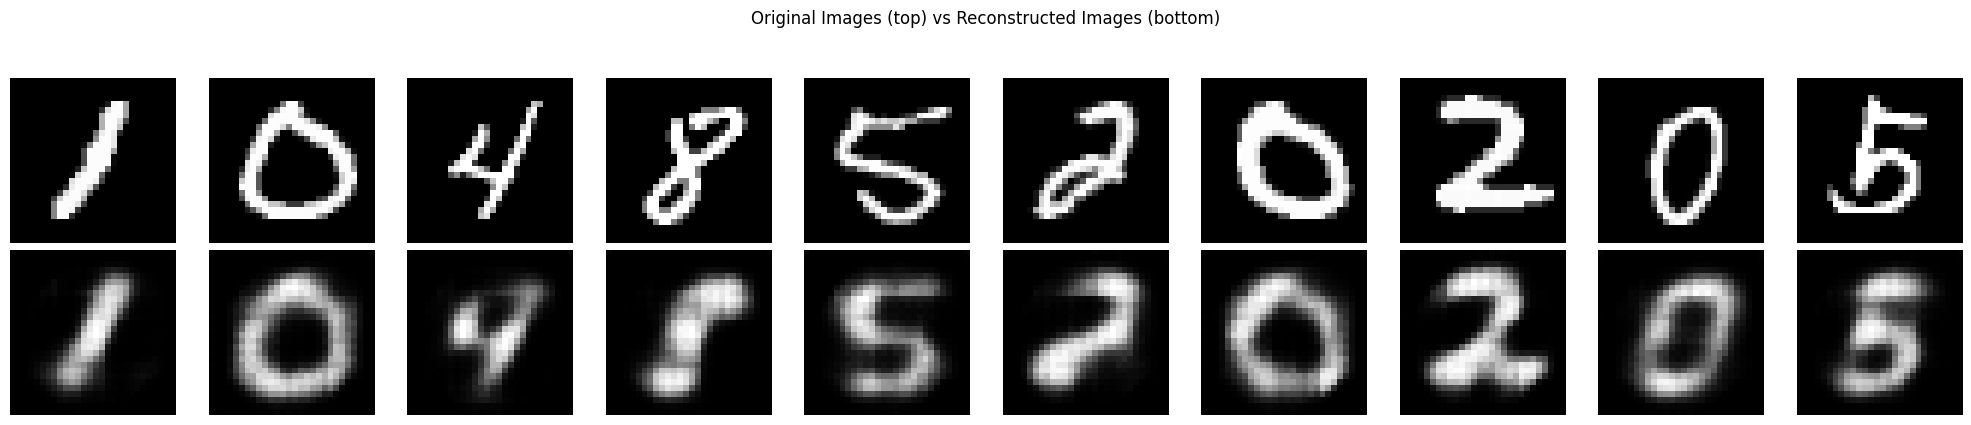

In [86]:
visualize_reconstructions(model, train_dataset)

In [35]:
# After training is complete
model.save("mnist_prototype_model.h5")

In [39]:
def visualize_weight_matrix(model):
    # Get the weights from the classifier layer (prototype to class weights)
    weights = model.classifier.get_weights()[0]  # Shape: [n_prototypes, n_classes]

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Display the weight matrix
    im = ax.imshow(weights, cmap='RdBu_r')

    # Set labels
    class_names = [str(i) for i in range(10)]  # MNIST digits 0-9

    # Add colorbar
    plt.colorbar(im)

    # Configure axes
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_xlabel('Digit Classes')
    ax.set_ylabel('Prototypes')

    # Add numbers in cells
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            text = ax.text(j, i, f'{weights[i, j]:.2f}',
                         ha="center", va="center",
                         color="black" if abs(weights[i, j]) < 10 else "white")

    plt.title("Prototype-to-Class Weight Matrix")
    plt.tight_layout()
    plt.show()

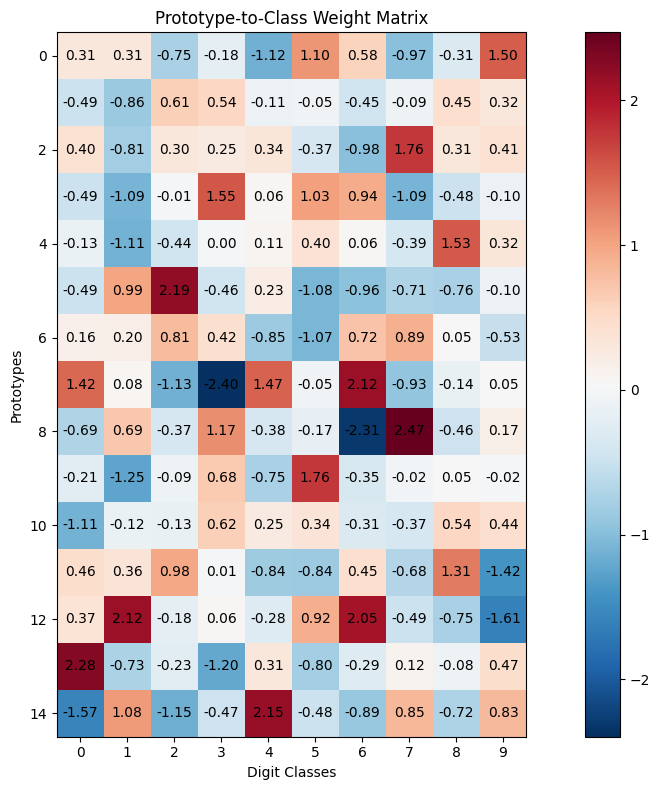

In [ ]:
# After training the model
visualize_weight_matrix(model)

In [41]:
def visualize_image_class_weights(model, dataset):
    # Get one sample image from each class
    images_by_class = [[] for _ in range(10)]
    for x_batch, y_batch in dataset:
        y_labels = tf.argmax(y_batch, axis=1)
        for img, label in zip(x_batch, y_labels):
            images_by_class[label.numpy()].append(img)
        if all(len(c) > 0 for c in images_by_class):
            break

    # Select first image from each class
    sample_images = [class_images[0] for class_images in images_by_class]
    sample_images = tf.stack(sample_images)

    # Get logits through the model
    logits, _, features, _ = model(sample_images)

    # Create figure with proper sizing
    fig = plt.figure(figsize=(15, 10))
    gs = plt.GridSpec(2, 1, height_ratios=[4, 1])

    # Plot weight matrix
    ax_weights = fig.add_subplot(gs[0])
    im = ax_weights.imshow(logits.numpy(), cmap='RdBu_r')
    plt.colorbar(im)

    # Add weight values in cells
    for i in range(logits.shape[0]):
        for j in range(logits.shape[1]):
            text_color = 'white' if abs(logits[i, j]) > 10 else 'black'
            ax_weights.text(j, i, f'{logits[i, j]:.2f}',
                          ha='center', va='center', color=text_color)

    # Plot sample digits on right side
    ax_images = fig.add_subplot(gs[1])
    for i in range(10):
        ax_images.imshow(sample_images[i],
                        extent=[i-0.5, i+0.5, 0, 1],
                        cmap='gray')

    # Configure axes
    ax_weights.set_xticks(range(10))
    ax_weights.set_xticklabels(range(10))
    ax_weights.set_ylabel('Input Images')
    ax_weights.set_xlabel('Digit Classes')
    ax_images.set_xticks([])
    ax_images.set_yticks([])

    plt.suptitle('Image-to-Class Weight Matrix')
    plt.tight_layout()
    plt.show()

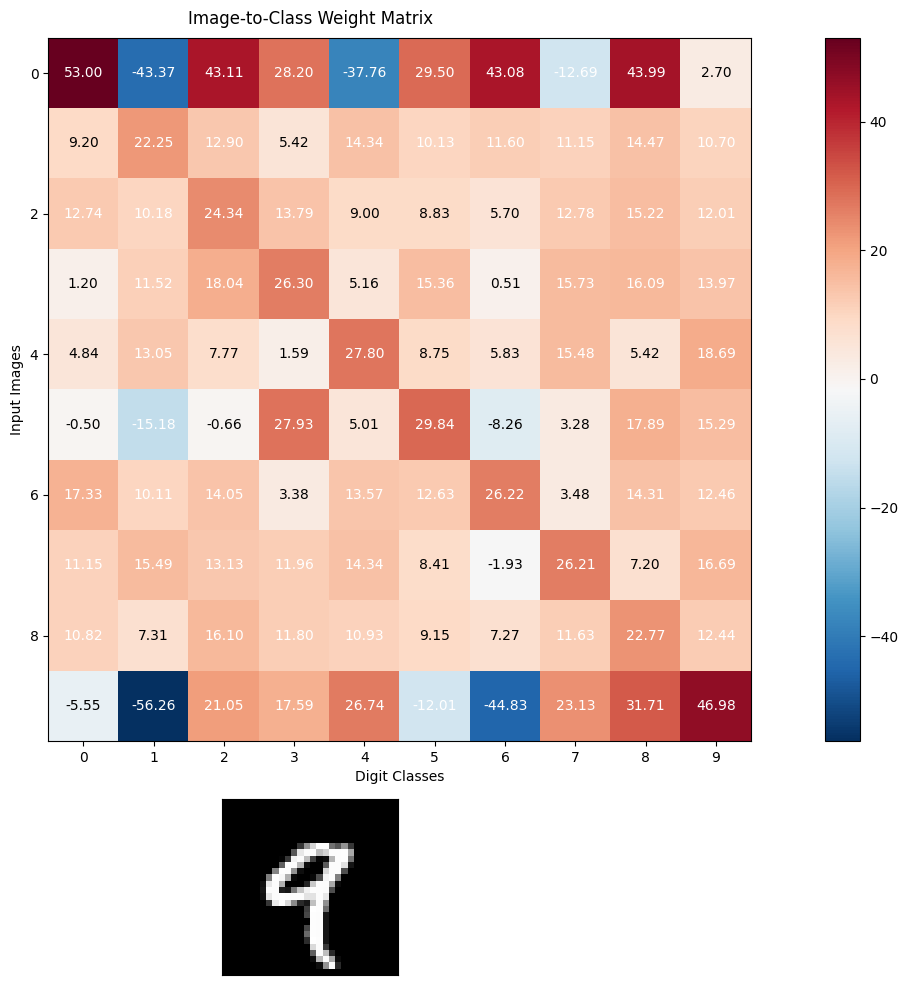

In [ ]:
visualize_image_class_weights(model, train_dataset)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 4, 4, 10)       │         2,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 160)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,706 (84.79 KB)

 Trainable params: 21,706 (84.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 160)            │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 4, 4, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_16             │ (None, 6, 6, 32)       │         2,912 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_17             │ (None, 12, 12, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_19             │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,457 (185.38 KB)

 Trainable params: 47,457 (185.38 KB)

 Non-trainable params: 0 (0.00 B)

None


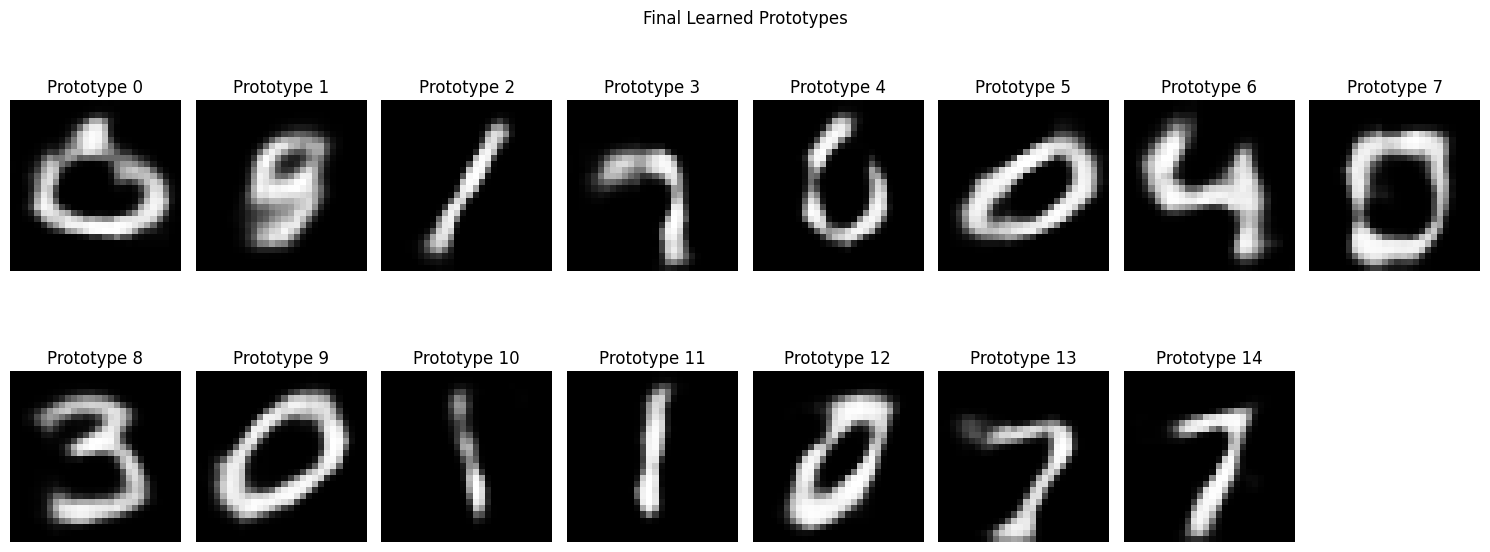

In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_trained_model(model_path):
    """
    Load the trained prototype autoencoder model
    """
    model = PrototypeAutoencoder(input_shape=(28, 28, 1), n_classes=10, n_prototypes=15)

    # Create a dummy input to build the model
    dummy_input = tf.zeros((1, 28, 28, 1))
    model(dummy_input)

    # Load weights
    model.load_weights(model_path)
    return model

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_final_prototypes(model):
    """
    Visualize the final learned prototypes in image space
    """
    # Decode prototype vectors to image space
    prototypes = model.prototype_vectors.numpy()

    # Decode prototypes
    decoded_prototypes = model.decoder(prototypes).numpy()

    # Reshape to 28x28 images
    decoded_prototypes = decoded_prototypes.reshape(-1, 28, 28)

    # Plot decoded prototypes
    plt.figure(figsize=(15, 6))
    for i in range(len(decoded_prototypes)):
        plt.subplot(2, 8, i + 1)
        plt.imshow(decoded_prototypes[i], cmap='gray')
        plt.title(f'Prototype {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle('Final Learned Prototypes', y=1.02)
    plt.show()

def visualize_prototype_activations(model, test_dataset):
    """
    Visualize prototype activations for individual images
    """
    # Iterate through test dataset
    for x_batch, y_batch in test_dataset.take(1):
        # Get model outputs
        logits, _, features, prototype_distances = model(x_batch)

        # Number of images to visualize
        num_images = min(5, x_batch.shape[0])

        # Create a large figure
        plt.figure(figsize=(20, 4 * num_images))

        for i in range(num_images):
            # Original image
            plt.subplot(num_images, 16, i * 16 + 1)
            plt.imshow(x_batch[i].numpy().squeeze(), cmap='gray')
            plt.title('Original')
            plt.axis('off')

            # Prototype distances for this image
            image_prototype_distances = prototype_distances[i].numpy()

            # Compute activations (lower distance means higher activation)
            activations = -image_prototype_distances

            # Normalize activations
            activations = (activations - activations.min()) / (activations.max() - activations.min())

            # Visualize each prototype's activation
            for p in range(len(activations)):
                plt.subplot(num_images, 16, i * 16 + p + 2)

                # Get the prototype
                prototype = model.prototype_vectors[p].numpy().reshape(4, 4, 10)

                # Visualize the first channel of the prototype
                plt.imshow(prototype[:,:,0], cmap='viridis', alpha=0.7)
                plt.title(f'P{p}\n{activations[p]:.2f}')
                plt.axis('off')

        plt.tight_layout()
        plt.suptitle('Prototype Activations for Test Images', y=1.02)
        plt.show()

# Load the trained model
model = load_trained_model("mnist_prototype_model.h5")

# Visualize final prototypes
visualize_final_prototypes(model)

# Visualize prototype activations
# visualize_prototype_activations(model, test_dataset)


Classification Accuracy: 93.10%


2024-12-10 12:40:57.119982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


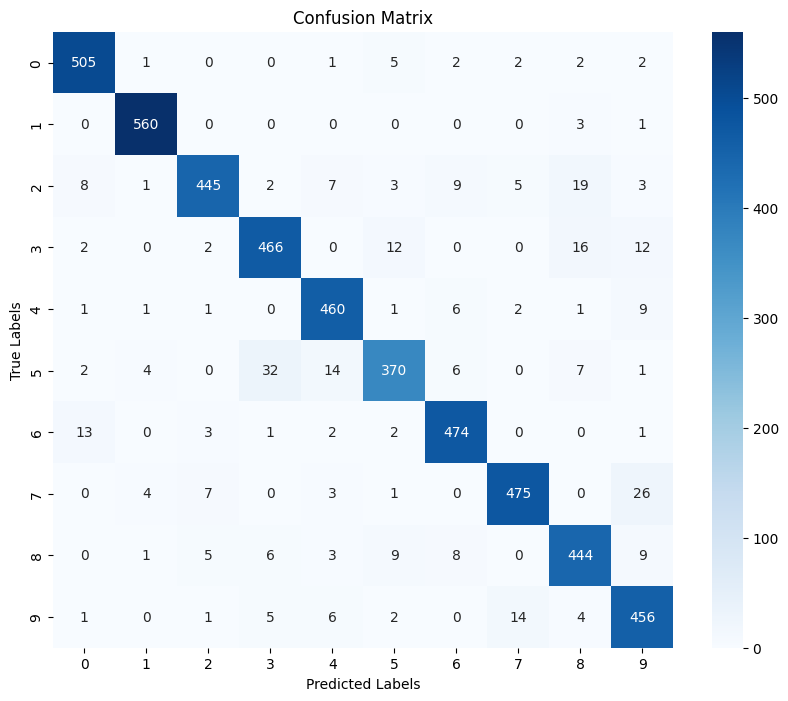


Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.97      0.96       520
     Class 1       0.98      0.99      0.99       564
     Class 2       0.96      0.89      0.92       502
     Class 3       0.91      0.91      0.91       510
     Class 4       0.93      0.95      0.94       482
     Class 5       0.91      0.85      0.88       436
     Class 6       0.94      0.96      0.95       496
     Class 7       0.95      0.92      0.94       516
     Class 8       0.90      0.92      0.91       485
     Class 9       0.88      0.93      0.90       489

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



In [38]:
def evaluate_classification_accuracy_prototype(model, test_dataset):
    """
    Evaluate classification accuracy of the prototype-based model.

    Args:
    - model: Trained prototype-based model.
    - test_dataset: Test dataset.

    Returns:
    - Accuracy
    - Confusion Matrix
    - True and Predicted Labels
    """
    # Collect true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate through the test dataset
    for batch in test_dataset:
        # Unpack images and labels
        images, labels = batch

        # Ensure images are in the right shape
        if len(images.shape) == 3:
            images = tf.expand_dims(images, axis=-1)

        # Forward pass through the model
        logits, *_ = model(images)  # Get logits directly

        # Predict class with the highest logit
        predictions = tf.argmax(logits, axis=1)

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = tf.argmax(labels, axis=1)

        # Extend the lists
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predictions.numpy())

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate accuracy
    accuracy = np.mean(true_labels == predicted_labels)

    # Compute confusion matrix
    confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predicted_labels,
        num_classes=10  # Assuming 10 classes (e.g., MNIST)
    ).numpy()

    return accuracy, confusion_matrix, true_labels, predicted_labels
# Evaluate the prototype model
accuracy, conf_matrix, true_labels, predicted_labels = evaluate_classification_accuracy_prototype(model, test_dataset)

# Print results
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Generate and print classification report
from sklearn.metrics import classification_report
report = classification_report(true_labels, predicted_labels, target_names=[f'Class {i}' for i in range(10)])
print("\nDetailed Classification Report:")
print(report)
